In [2]:
import pandas
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
names = 'egamma calibration', 'Photon ID', 'T&P', 'Egamma meeting'

pd_contributions = pandas.concat([pandas.read_pickle(s + "_contributions.pkl") for s in names])
pd_meeting = pandas.concat([pandas.read_pickle(s + '_meeting.pkl') for s in names])

pd_meeting_grouped_by_mytitle = pd_meeting.groupby('my_title')
pd_joined = pd_contributions.join(pd_meeting, on='id_meeting', lsuffix='_contribution')

pd_contributions_HSG1 = pandas.read_pickle("HSG1_contributions.pkl")
pd_meeting_HSG1 = pandas.read_pickle("HSG1_meeting.pkl")
pd_joined_HSG1 = pd_contributions_HSG1.join(pd_meeting_HSG1, on='id_meeting', lsuffix='_contribution')

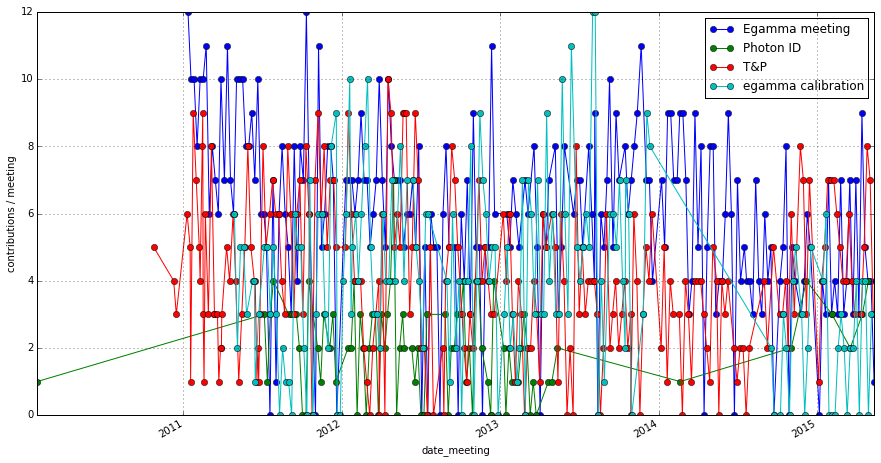

In [8]:
f, ax = plt.subplots(figsize=(15, 8))
l = []

for key, grp in pd_meeting_grouped_by_mytitle:
    l.append(key)
    grp.plot(ax=ax,x='date_meeting', y='contributions', ls='-', marker='o')
ax.legend(l)
ax.set_ylabel('contributions / meeting')

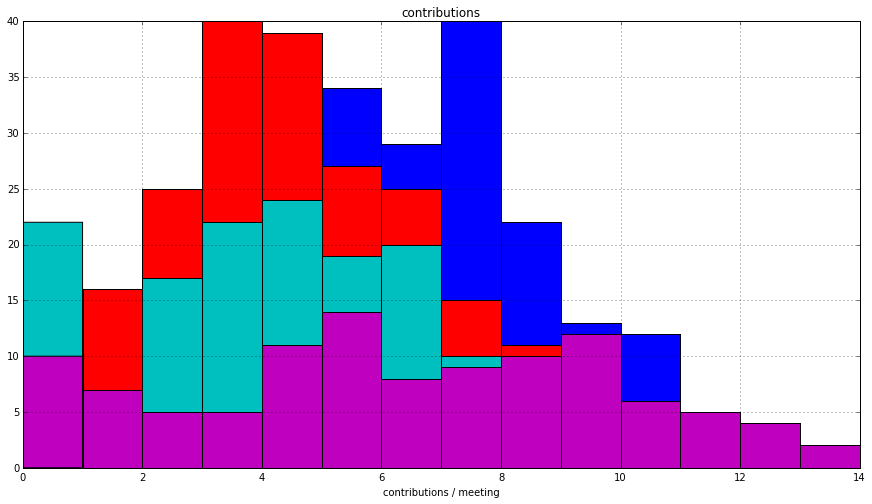

In [33]:
f, ax = plt.subplots(figsize=(15, 8))

pd_meeting_grouped_by_mytitle['contributions'].hist(ax=ax, bins=np.arange(0, 15), alpha=0.5)
pd_meeting_HSG1.hist(ax=ax, bins=np.arange(0, 15))
ax.set_xlabel('contributions / meeting')
ax.legend()

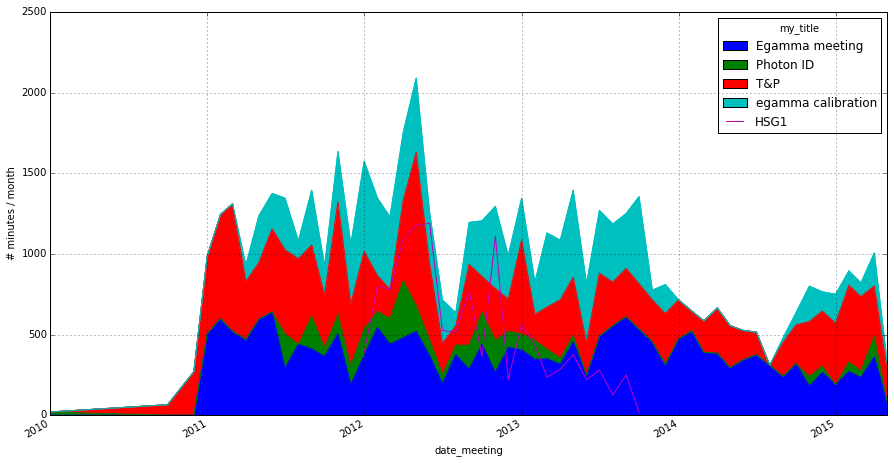

In [34]:
f, ax = plt.subplots(figsize=(15, 8))
pd_joined.groupby([pandas.Grouper(freq='1MS',key='date_meeting'), 'my_title'])['duration'].sum().unstack().fillna(0).plot(kind='area', ax=ax)
pd_joined_HSG1.groupby([pandas.Grouper(freq='1MS',key='date_meeting'), 'my_title'])['duration'].sum().unstack().fillna(0).plot(ax=ax)
ax.set_ylabel('# minutes / month')

/usr/lib64/python2.7/site-packages/pandas/core/frame.py:3176: FutureWarning: TimeSeries broadcasting along DataFrame index by default is deprecated. Please use DataFrame.<op> to explicitly broadcast arithmetic operations along the index
  FutureWarning)


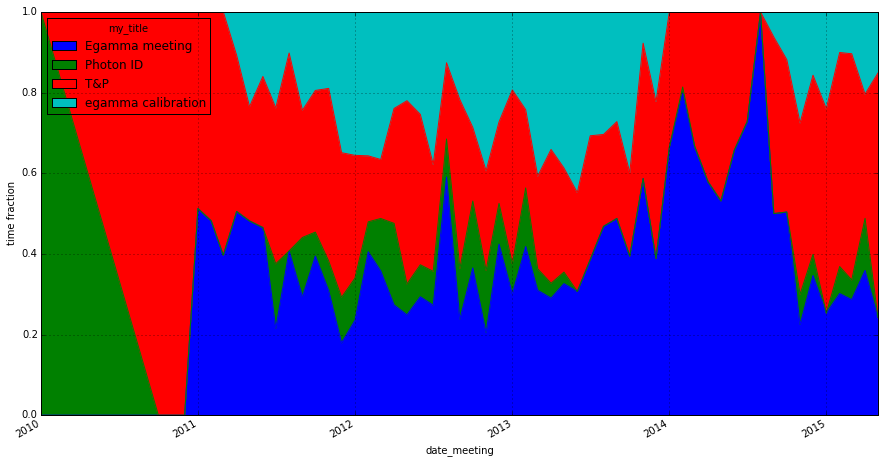

In [7]:
f, ax = plt.subplots(figsize=(15, 8))
(pd_joined.groupby([pandas.Grouper(freq='1MS',key='date_meeting'), 'my_title'])['duration'].sum().unstack().fillna(0) / pd_joined.groupby([pandas.Grouper(freq='1MS',key='date_meeting')])['duration'].sum()).plot(kind='area', ax=ax)
ax.set_ylabel('time fraction')

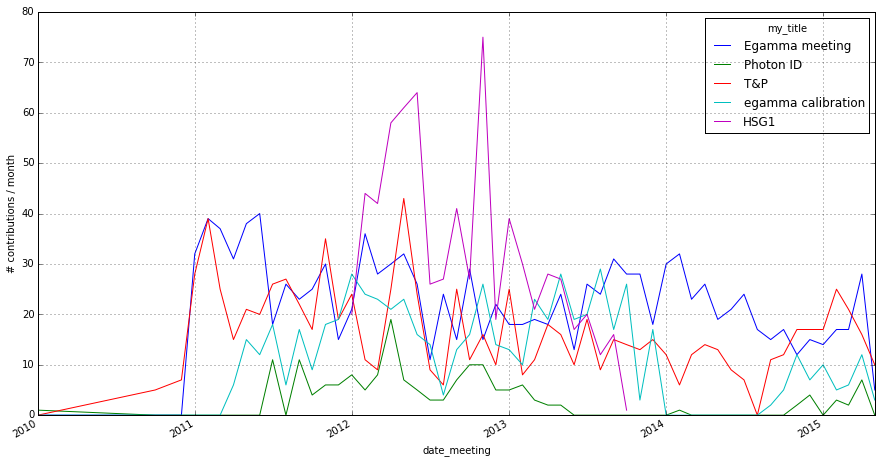

In [35]:
import matplotlib.dates as mdates
f, ax = plt.subplots(figsize=(15, 8))
pd_meeting.groupby([pandas.Grouper(freq='MS',key='date_meeting'), 'my_title'])['contributions'].sum().unstack().fillna(0).plot(ax=ax)
pd_meeting_HSG1.groupby([pandas.Grouper(freq='MS',key='date_meeting'), 'my_title'])['contributions'].sum().unstack().fillna(0).plot(ax=ax)
ax.set_ylabel('# contributions / month')

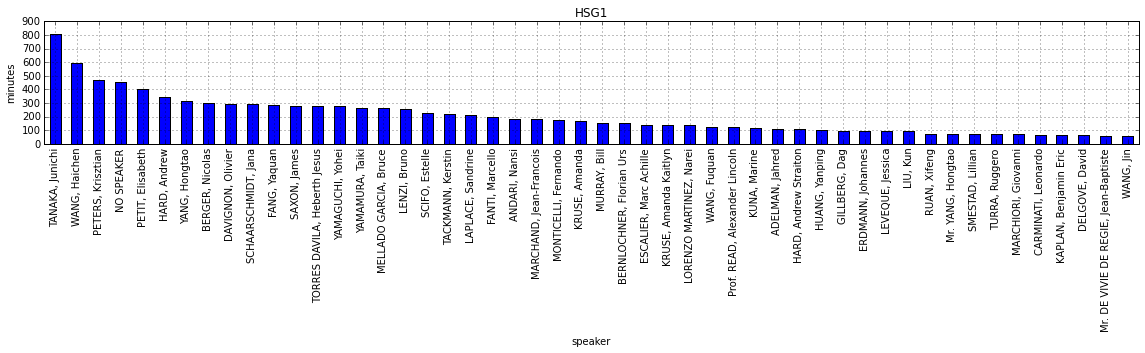

In [37]:
g = pd_joined_HSG1.groupby(['my_title'])['speaker','duration']

for k, v in g:
    f, ax = plt.subplots(figsize=(16, 5))
    v.groupby('speaker')['duration'].sum().sort('duration', inplace=False, ascending=False)[:50].plot(kind='bar', ax=ax)
    ax.set_ylabel('minutes')
    ax.set_title(k)
    f.tight_layout()

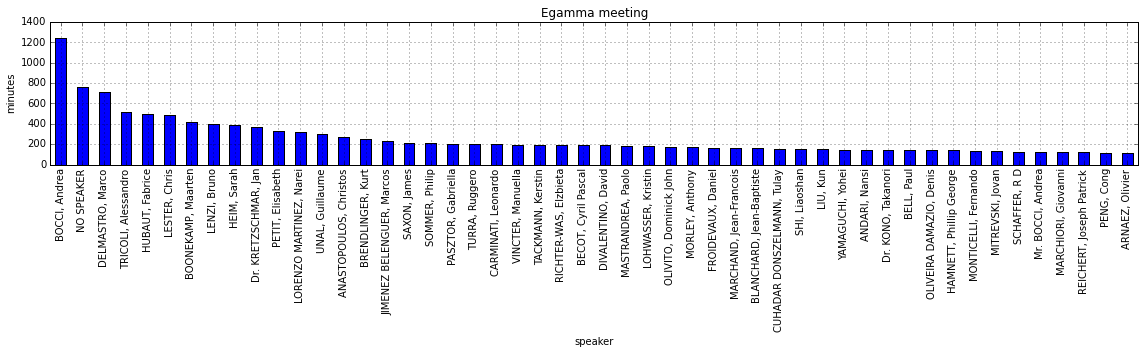

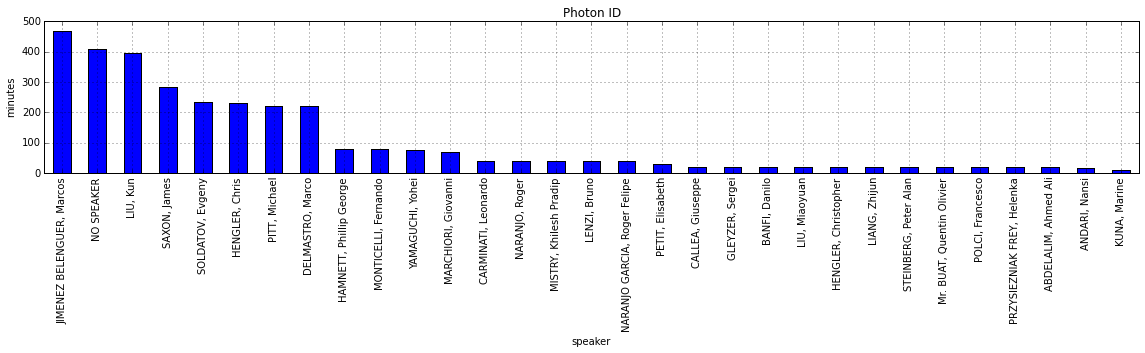

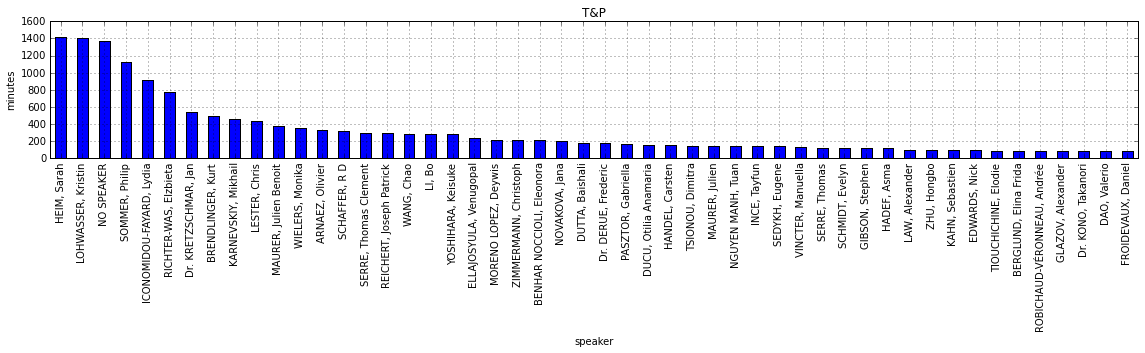

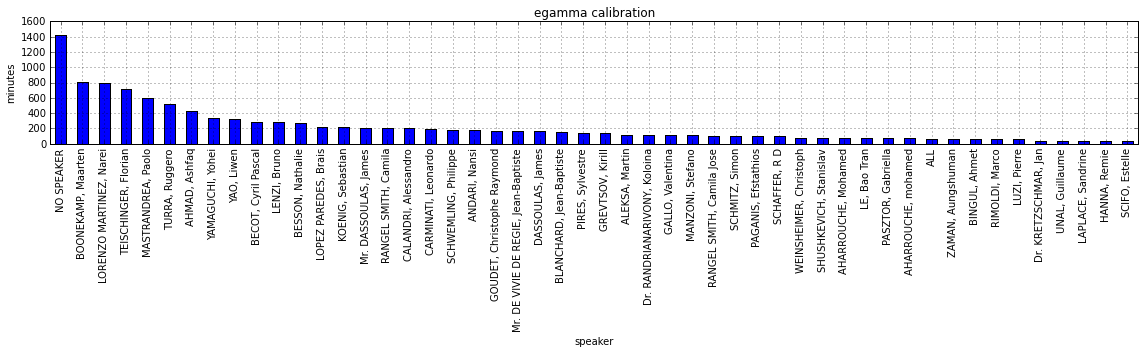

In [36]:
g = pd_joined.groupby(['my_title'])['speaker','duration']

for k, v in g:
    f, ax = plt.subplots(figsize=(16, 5))
    v.groupby('speaker')['duration'].sum().sort('duration', inplace=False, ascending=False)[:50].plot(kind='bar', ax=ax)
    ax.set_ylabel('minutes')
    ax.set_title(k)
    f.tight_layout()

Axes(0.125,0.125;0.775x0.775)
Axes(0.125,0.125;0.775x0.775)


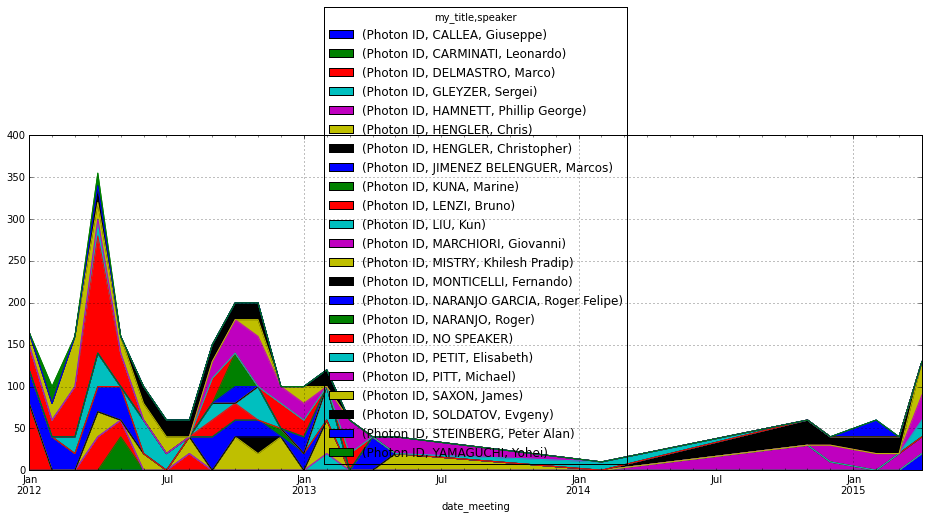

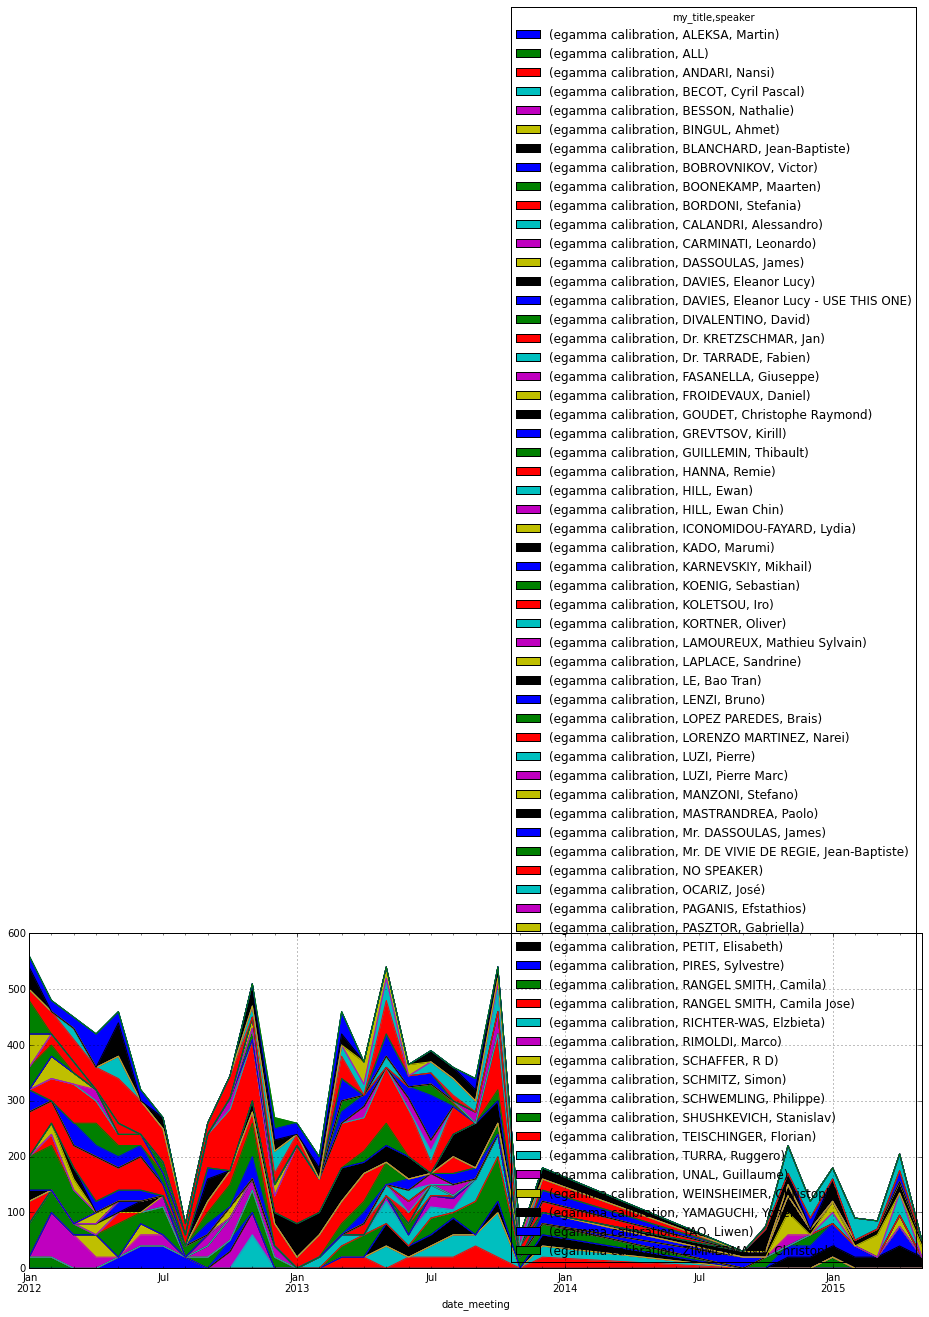

In [129]:
for k, v in pd_joined.groupby('my_title'):
    print v.groupby(['my_title', pandas.Grouper(freq='MS',key='date_meeting'), 'speaker'])['duration'].sum().unstack('my_title').unstack().plot(kind='area', stacked=True, figsize=(16, 6))


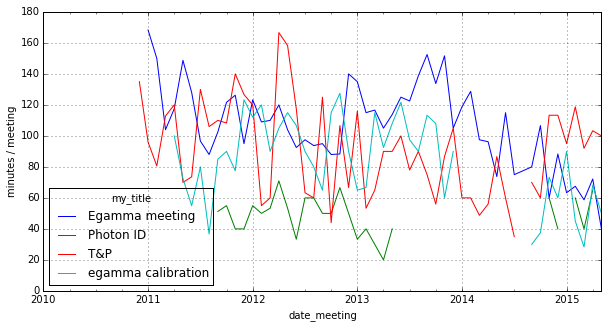

In [11]:
s = pd_joined.groupby(['date_meeting', 'my_title'])["duration"].sum().unstack()
s['date_meeting'] = s.index
ax = s.groupby(pandas.Grouper(freq='1MS',key='date_meeting')).mean().plot(figsize=(10, 5))
ax.set_ylabel('minutes / meeting')

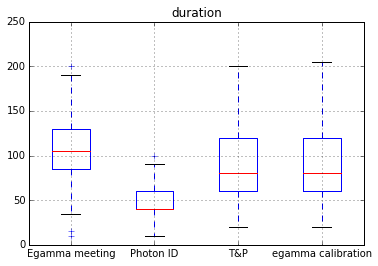

In [12]:
ax = pd_joined.groupby(['date_meeting', 'my_title'])["duration"].sum().unstack('my_title').plot(kind='box')
ax.set_title('duration')

In [38]:
words = pd_contributions['title'].apply(lambda x: x.lower()).apply(lambda x: x.split()).sum()
words_HSG1 = pd_contributions_HSG1['title'].apply(lambda x: x.lower()).apply(lambda x: x.split()).sum()

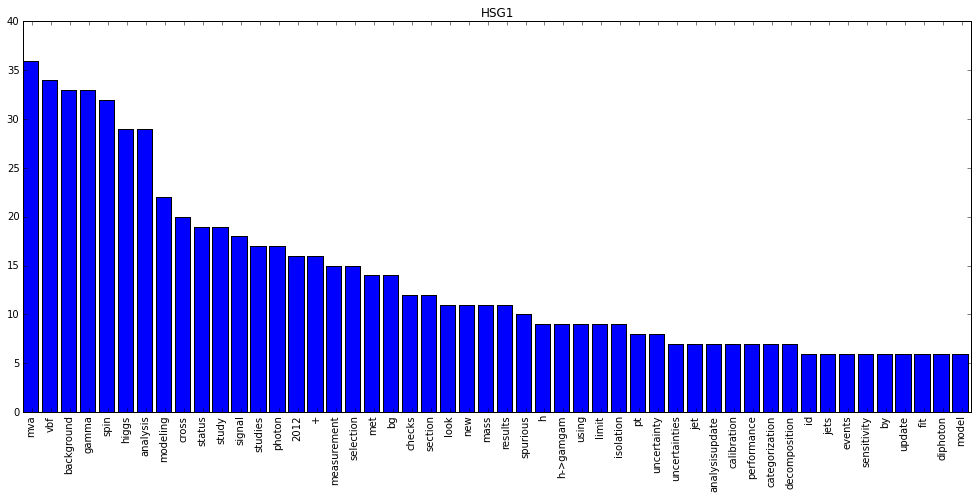

In [39]:
from collections import Counter
common_words = 'on -> with for - in ; : & the of and from at a to from by'.split()


for k, v in pd_joined.groupby('my_title')['title_contribution'].sum().str.lower().str.split().to_dict().iteritems():
    words = filter(lambda x: x not in common_words, v)

    histo_words = Counter(words)
    values = np.array(histo_words.values())
    labels = np.array(histo_words.keys())
    idx = np.argsort(values)[::-1]
    
    fig, ax = plt.subplots(figsize=(17, 7))
    ax.bar(np.arange(50), values[idx][:50])
    ax.set_xticklabels(labels[idx][:100], rotation=90)
    ax.set_xticks(np.arange(50) + 0.5)
    ax.set_title(k)
plt.show()

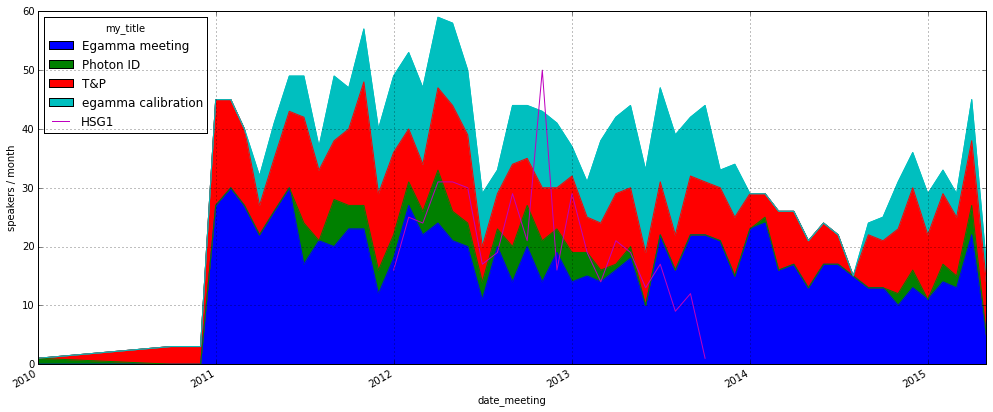

In [40]:
fig, ax = plt.subplots(figsize=(17, 7))
pd_joined.groupby([pandas.Grouper(freq='1MS',key='date_meeting'), 'my_title'])['speaker'].unique().apply(lambda x: len(x)).unstack().plot(ax=ax, kind='area')
pd_joined_HSG1.groupby([pandas.Grouper(freq='1MS',key='date_meeting'), 'my_title'])['speaker'].unique().apply(lambda x: len(x)).unstack().plot(ax=ax)
ax.set_ylabel('speakers / month')

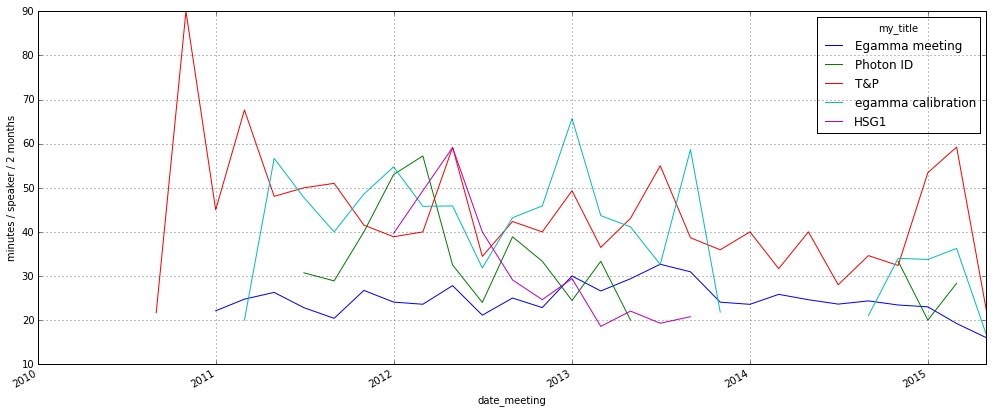

In [41]:
fig, ax = plt.subplots(figsize=(17, 7))
((pd_joined.groupby([pandas.Grouper(freq='2MS',key='date_meeting'), 'my_title'])['duration'].sum().unstack().fillna(0)) / pd_joined.groupby([pandas.Grouper(freq='2MS',key='date_meeting'), 'my_title'])['speaker'].unique().apply(lambda x: len(x)).unstack()).plot(ax=ax)
((pd_joined_HSG1.groupby([pandas.Grouper(freq='2MS',key='date_meeting'), 'my_title'])['duration'].sum().unstack().fillna(0)) / pd_joined_HSG1.groupby([pandas.Grouper(freq='2MS',key='date_meeting'), 'my_title'])['speaker'].unique().apply(lambda x: len(x)).unstack()).plot(ax=ax)
ax.set_ylabel('minutes / speaker / 2 months')